DATA CREATION

Simulate an A/B experiment on a website's “Start Free Trial” button redesign.
The goal is to test whether Version B (new design) leads to better conversion than Version A.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(24)

n = 2000

df = pd.DataFrame({
    'User_ID': np.arange(1, n+1),
    'Group': np.random.choice(['A', 'B'], size=n),
    'Page_Load_Time': np.round(np.random.normal(2.5, 0.5, n), 2),
})

# Simulate conversion rates
df['Converted'] = df.apply(lambda row: 
    np.random.binomial(1, 0.11) if row['Group'] == 'A' else np.random.binomial(1, 0.13), axis=1)

df.to_csv("ab_test_data.csv", index=False)


## Task:
1. Analyze Results:
    - What’s the conversion rate for A vs B?
    - Did the change make a statistically significant difference?
        - Use z-test or chi-square test for proportions.
        - Show your hypothesis clearly.

2. Dig Deeper:
    - Analyze conversion by Page_Load_Time — does slower loading affect conversions more for one group?
    - Visualize this (e.g., bins of load time vs conversion rate).

3. Make a Recommendation:
    - Should the company roll out Version B?
    - If not, what would you test next?

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User_ID         2000 non-null   int64  
 1   Group           2000 non-null   object 
 2   Page_Load_Time  2000 non-null   float64
 3   Converted       2000 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 62.6+ KB


In [3]:
df.head()

,User_ID,Group,Page_Load_Time,Converted
0,1,A,1.87,0
1,2,B,3.16,0
2,3,A,2.06,0
3,4,B,1.91,0
4,5,B,2.97,0


In [7]:
df['Group'].value_counts()

Group
B    1014
A     986
Name: count, dtype: int64

In [8]:
df.groupby('Group')['Page_Load_Time'].mean()

Group
A    2.480385
B    2.497682
Name: Page_Load_Time, dtype: float64

In [13]:
df.groupby('Group')['Converted'].value_counts()

Group  Converted
A      0            880
       1            106
B      0            884
       1            130
Name: count, dtype: int64

In [38]:
# Conversion rate

Rate_A = df[df['Group'] == 'A']['Converted'].mean() * 100
print(f"Conversion Rate for Group A: {Rate_A:.2f}%")

Rate_B = df[df['Group'] == 'B']['Converted'].mean() * 100
print(f"Conversion Rate for Group B: {Rate_B:.2f}%")



Conversion Rate for Group A: 10.75%
Conversion Rate for Group B: 12.82%


In [40]:
from statsmodels.stats.proportion import proportions_ztest

# Get conversion counts and total counts
conversion_counts = df.groupby('Group')['Converted'].sum().values
n_obs = df.groupby('Group')['Converted'].count().values

z_stat, p_val = proportions_ztest(count=conversion_counts, nobs=n_obs, alternative='larger')

print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_val:.4f}")


Z-Statistic: -1.4346
P-Value: 0.9243


In [41]:
df['Load_Bin'] = pd.cut(df['Page_Load_Time'], bins=[0, 1.5, 2.0, 2.5, 3.0, 3.5, 5], 
                        labels=['<1.5s', '1.5–2s', '2–2.5s', '2.5–3s', '3–3.5s', '3.5–5s'])


In [49]:
conversion_by_bin = df.groupby(['Group', 'Load_Bin'], observed = False)['Converted'].mean().unstack() * 100
print(conversion_by_bin)


Load_Bin      <1.5s     1.5–2s     2–2.5s     2.5–3s     3–3.5s   3.5–5s
Group                                                                   
A         19.047619   8.270677  11.420613  10.115607  12.264151  9.52381
B         10.714286  14.062500  12.834225  12.345679  13.669065  9.52381


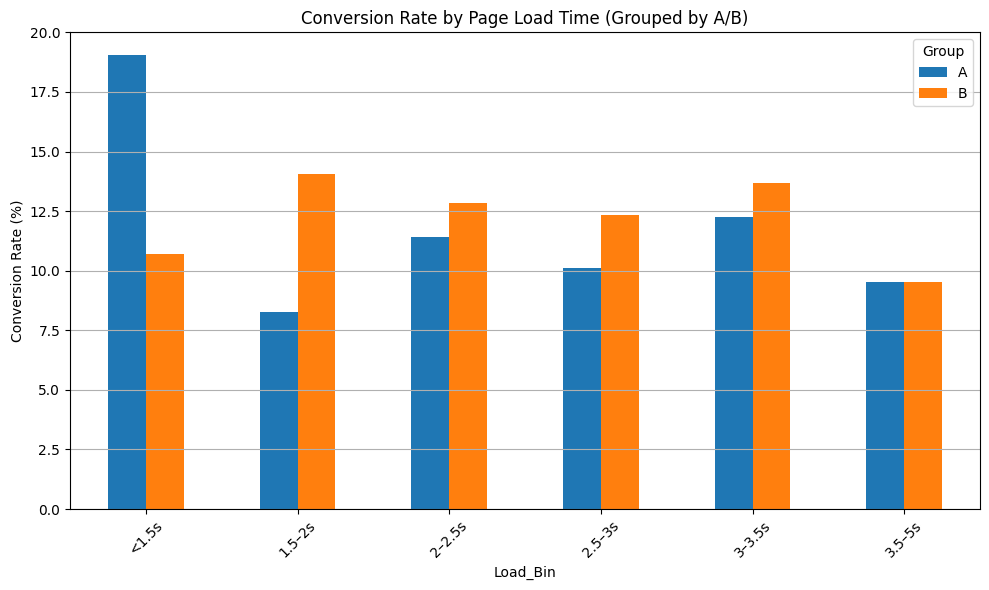

In [65]:
import matplotlib.pyplot as plt

conversion_by_bin.T.plot(kind='bar', figsize=(10,6))
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion Rate by Page Load Time (Grouped by A/B)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
